(torch.Size([200]), torch.Size([200]))

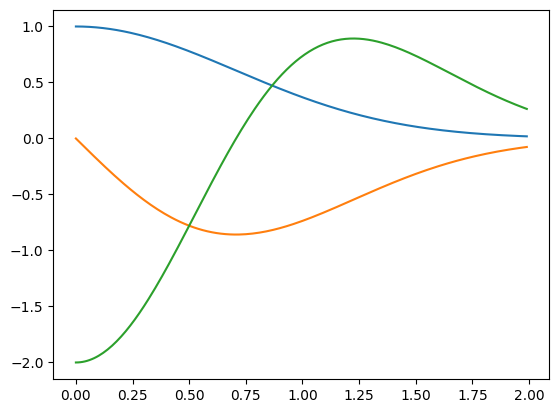

In [2]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(0,2,0.01)
y = torch.exp(-x*x)
y1 = -2*x*torch.exp(-x*x)
y2 = (4*x*x-2)*torch.exp(-x*x)
plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
x.size(),x.shape

In [3]:
def sequence_mask(x, valid_lens, value=0):
    max_len = x.size(1)
    mask = torch.arange(max_len, dtype=torch.float32,device=x.device)[None,:]<valid_lens[:,None]
    x[~mask] = value
    return x

def masked_softmax(x, valid_lens):
    if valid_lens is None:
        return torch.softmax(x,dim=-1)
    else:
        shape = x.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        x = sequence_mask(x.reshape(-1, shape[-1]), valid_lens, -1e6)
        return torch.softmax(x.reshape(shape),dim=-1)

masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6756, 0.3244, 0.0000, 0.0000],
         [0.4564, 0.5436, 0.0000, 0.0000]],

        [[0.4475, 0.3668, 0.1857, 0.0000],
         [0.2935, 0.3235, 0.3830, 0.0000]]])

In [5]:
class AdditiveAttention(torch.nn.Module):
    def __init__(self, key_size, query_size, hidden_size, dropout):
        super().__init__()
        self.w_k = torch.nn.Linear(key_size, hidden_size, False)
        self.w_q = torch.nn.Linear(query_size, hidden_size, False)
        self.w_v = torch.nn.Linear(hidden_size, 1, False)
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries = self.w_q(queries)
        keys = self.w_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)



In [6]:
queries = torch.normal(0,1, (2,1,20))
keys = torch.ones((2,10,2))
values = torch.arange(40,dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens=torch.tensor([2,6])
attention = AdditiveAttention(2, 20, 8, 0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [14]:
import math

class DotProductAttention(torch.nn.Module):
    def __init__(self, dropout, **kwargs) -> None:
        super().__init__(**kwargs)
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        d= queries.size(-1)
        scores = torch.bmm(queries, keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        print(scores.shape,self.attention_weights.shape, values.shape)
        return torch.bmm(self.dropout(self.attention_weights),values)



In [15]:
queries = torch.normal(0, 1, (2, 2, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 2, 10]) torch.Size([2, 2, 10]) torch.Size([2, 10, 4])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000]]])

In [24]:
a = torch.normal(0,1,(10,))
a, torch.softmax(a,dim=0),torch.softmax(a*4,dim=0),

(tensor([ 0.2863, -0.6600,  1.0674, -0.2451, -0.2668, -1.2330, -0.4607, -1.6666,
         -1.5519,  0.4579]),
 tensor([0.1446, 0.0561, 0.3158, 0.0850, 0.0832, 0.0316, 0.0685, 0.0205, 0.0230,
         0.1717]),
 tensor([3.8401e-02, 8.7208e-04, 8.7357e-01, 4.5850e-03, 4.2031e-03, 8.8135e-05,
         1.9353e-03, 1.5558e-05, 2.4610e-05, 7.6301e-02]))